In [43]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [44]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = "model/keypoint_classifier/keypoint_classifier.keras"


In [45]:
NUM_CLASSES = 9

In [46]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [47]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [50]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_4 (Dropout)                  │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │             860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [52]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2615 - loss: 2.1795


In [54]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [55]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
[8.2451583e-09 5.1192826e-01 2.4087318e-05 8.9356430e-02 3.6606991e-06
 8.9608866e-04 3.9746997e-01 3.0664750e-04 1.4803184e-05]
1


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step


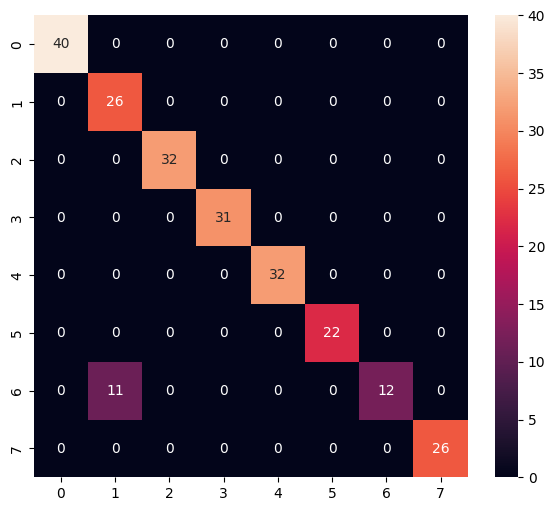

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.70      1.00      0.83        26
           2       1.00      1.00      1.00        32
           3       1.00      1.00      1.00        31
           4       1.00      1.00      1.00        32
           5       1.00      1.00      1.00        22
           6       1.00      0.52      0.69        23
           7       1.00      1.00      1.00        26

    accuracy                           0.95       232
   macro avg       0.96      0.94      0.94       232
weighted avg       0.97      0.95      0.95       232



In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [57]:

model.save(model_save_path, include_optimizer=False)

In [58]:
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\LOHITH\AppData\Local\Temp\tmp_0681jm8\assets


INFO:tensorflow:Assets written to: C:\Users\LOHITH\AppData\Local\Temp\tmp_0681jm8\assets


Saved artifact at 'C:\Users\LOHITH\AppData\Local\Temp\tmp_0681jm8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  2513868797136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2513868798288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2513868796368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2513868798096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2513868797520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2513870064912: TensorSpec(shape=(), dtype=tf.resource, name=None)


6760

In [59]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [60]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [61]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [62]:
%%time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [63]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.2451583e-09 5.1192832e-01 2.4087320e-05 8.9356415e-02 3.6606957e-06
 8.9608872e-04 3.9747006e-01 3.0664750e-04 1.4803186e-05]
1
